In [1]:
import torch
from torch import nn
import d2l_torch as d2l

+ nn.Conv2d()中stride默认为1，padding默认为0
+ Maxpool2d中，stride默认等于kernel_size,padding默认为0，dilation=1

## NiN块

In [14]:
def nin_block(in_channels,out_channels,kernel_size,stride,padding):
    sub_net=nn.Sequential(
    nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),nn.ReLU(),
    nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU(),
    nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU())
    return sub_net

+ NiN其实借鉴了AlexNet的块的思想，所以设计上很像AlexNet
+ 下面每个NiN块第一个卷积层的输出通道数，其实是对照AlexNet进行设置的。(只用了AlexNet的前三个卷积层，后面那几个成堆的卷积层没使用)

## NinNet


In [15]:
net=nn.Sequential(
    nin_block(1,96,kernel_size=11,stride=4,padding=0),
    nn.MaxPool2d(kernel_size=3,stride=2),  # (n+2p+s-k)/2(=n+2-3)/2=(n-1)/2,输出的feature map比上面小1，但是通道个数不变，每个通道的大小减1
    nin_block(96,256,kernel_size=5,stride=1,padding=2), # p=(k-1)/2 所以输出的大小不变 strides=1本来就是默认
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(256,384,kernel_size=3,stride=1,padding=1), # p=(k-1)/2 所以输出的大小不变 strides=1本来就是默认
    nn.MaxPool2d(kernel_size=3,stride=2),nn.Dropout(0.5),
    nin_block(384,10,kernel_size=3,stride=1,padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())

**注意，步幅这个参数就是 stride，没有s，不是strides，padding都不是paddings，沐神的代码在nin_block的形参里写的是strides，其实有问题**

上面代码其实有两个地方要注意
1. 那个dropout是怎么弄的，不是只有全连接层可以dropout，虽然那个1x1卷积层也算一个全连接层，但是这个dropout只在最后一个nin_block之前
2. 那个AdaptiveAvgPool2d输出的内容/维度，需要压平才可以出去计算？？

In [16]:
X=torch.rand((1,1,224,224))
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,"output shape: \t",X.shape)

Sequential output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Sequential output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Sequential output shape: 	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 384, 5, 5])
Dropout output shape: 	 torch.Size([1, 384, 5, 5])
Sequential output shape: 	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape: 	 torch.Size([1, 10, 1, 1])
Flatten output shape: 	 torch.Size([1, 10])


+ AdaptiveAvgPool2d output shape: 	 torch.Size([1, 10, 1, 1])
+ 上面这句其实就是，不管通道大小是多大，把这个通道的平均值拿出来。一共是$1\times 10$个通道，每个通道大小/feature map都是$5\times 5$

## 训练模型

loss 2.303, train acc 0.100, test acc 0.100
434.0 examples/sec on cuda:0


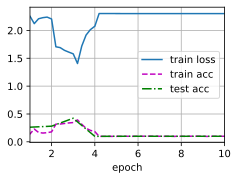

In [17]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())